### Exploratory data analysis of the Lending Club peer-to-peer loan portfolio

Lending Club, founded in 2006, was a pioneering peer-to-peer (P2P) lending platform in the US. It provided a marketplace where individual investors could fund loans directly for borrowers seeking personal loans, debt consolidation, or other financial needs.

A snapshot of their lending data taken in April 2019 (featuring originations to the end of 2018) can be obtaing from kaggle:
```
#!/bin/bash
curl -L -o ./lending-club.zip https://www.kaggle.com/api/v1/datasets/download/wordsforthewise/lending-club
unzip lending-club.zip
```

First, let's load the data into a pandas dataframe so we can do some simple exploratory analysis.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../lendingclub/accepted_2007_to_2018Q4.csv.gz', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


So, there are approvimately 2.25 million records in the dataset, where each represents an individual loan, and 151 attributes associated with each one. Let's check this is the case by ensuring there are no duplicate loan identifiers in the data.

In [4]:
assert not df.id.duplicated().any()

In [5]:
df.issue_d.isna().sum()

33

There are however, 33 records which have a number of (37) data points missing, including some critical information like `issue_d`! We'll drop those records for simplicity.

In [6]:
df = df[df.issue_d.notna()].reset_index(drop=True)

As we'd like to view performance in the portfolio over time we first need to convert some strings into python datetime values. Here we see the range of `last_pymnt_d` spanning 2007 through to March 2019 as expected. We'll take this as our snapshot date.

In [7]:
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df.last_pymnt_d = pd.to_datetime(df.last_pymnt_d, format='%b-%Y')
df.next_pymnt_d = pd.to_datetime(df.next_pymnt_d, format='%b-%Y')

In [8]:
df.last_pymnt_d.agg(['min', 'median', 'max'])

min      2007-12-01
median   2018-08-01
max      2019-03-01
Name: last_pymnt_d, dtype: datetime64[ns]

In [9]:
snapshot_date = df.last_pymnt_d.max()

If no payments have been made at all, ensure `last_pymnt_d` is populated even with the date of issue, and bump all month-0 payments to the following month.

In [10]:
df.last_pymnt_d.isna().sum()

2427

In [11]:
df.last_pymnt_d = df.last_pymnt_d.combine_first(df.issue_d)
df.loc[df.issue_d==df.last_pymnt_d, 'last_pymnt_d'] = df.last_pymnt_d + pd.tseries.offsets.DateOffset(months=1)

### Plots of originations as a function of some categorical attributes

Below we plot the total value of lending over time, coloured according to a few dimensions of particular interest, starting with the loan term. Such plots are a useful way to easily visualise how the composition of the loan portfolio might have changed over time with changes to company strategy, investor appetite, or macro-economic conditions.

Lending Club offered loans over 3 or 5 year terms, with a slight bias (even when $-weighted) towards 36 month terms. Here we see that although the company was founded in 2006, volumnes only really started to ramp up in the mid-2010s.

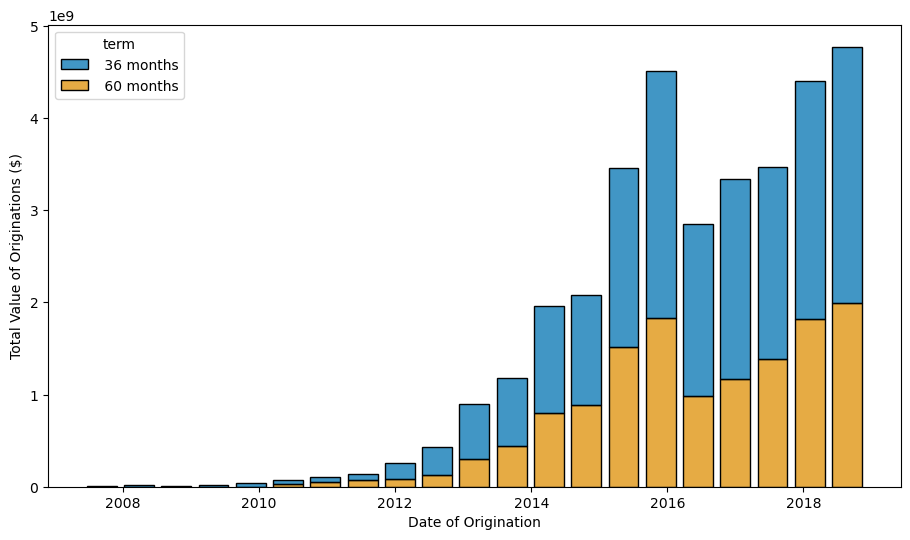

In [12]:
def originations_timeline(df: pd.DataFrame, category: str):
    
    plt.figure(figsize=(11, 6))
    ax = sns.histplot(
        df, x='issue_d', hue=category, weights='loan_amnt',
        multiple='stack', shrink=0.8, bins=21, palette='colorblind')
    ax.set_xlabel('Date of Origination')
    ax.set_ylabel('Total Value of Originations ($)')

originations_timeline(df, 'term')

Though the ratio between 36 and 60 month loans appears to be fairly stable over time, the point when this snapshot was taken (April 2019) dictates that very few of the 5 year loans are likely to have reached maturity. As we are thinking about modelling this dataset, on the face of it we have 3 not terribly attractive options:

- Select only those loans originated prior to April 2014 to ensure all accounts are fully matured at the point when the snapshot was taken. This would naturally lose the majority of the records and leave us with a model that's well out of date.
- Select only those 36 month loans originated prior to April 2016. This brings the model slightly more up to date but again loses a vast amount of data in the 60 month loans.
- Take another aribtrary cutoff date (e.g. October 2017?) and assume that those loans will remain in their current status until they have reached maturity. This is not a sound assumption as delinquency inevitably increases over time, biasing perception towards reduced risk for the immature accounts than those that are truly mature.

Below, we look at the purpose for taking out the loan as reported by the borrower at the time of their application. As is typical for a consumer credit portfolio of this type, the majority of the applications are for refinancing purposes, i.e. `debt_consolidation` and paying off existing `credit_card` balances.

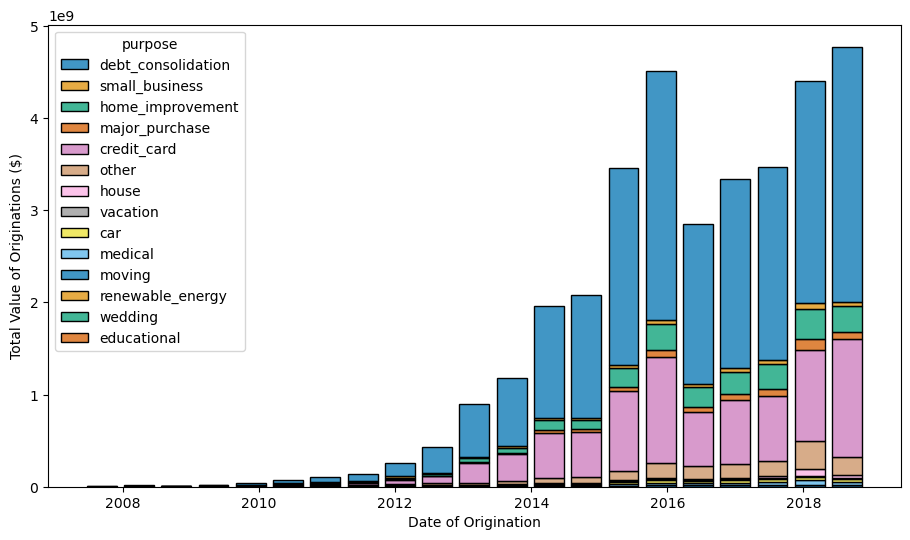

In [13]:
originations_timeline(df, 'purpose')

### Plots of originations as a function of some continuous attributes

Two other properties we might also be very interested in are the interest rate at which credit was extended to the borrower, and a 3rd party credit score to provide an indication of the credit quality. Both are continuous attributes so require binning to plot in this format.

Below we see the interest rates paid by the borrowers ranging from 5 - 30% and FICO scores of 610 - 850. Again, both attributes appear to be reasonably stable over time.

In [14]:
df['int_rate_qcut'] = pd.qcut(df.int_rate, q=7)
df['fico_range_high_qcut'] = pd.qcut(df.fico_range_high, q=7)

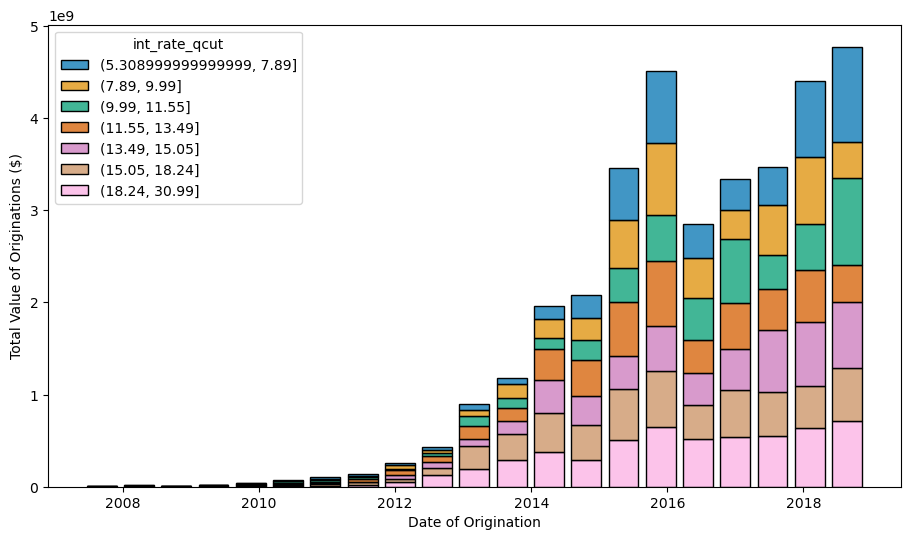

In [15]:
originations_timeline(df, 'int_rate_qcut')

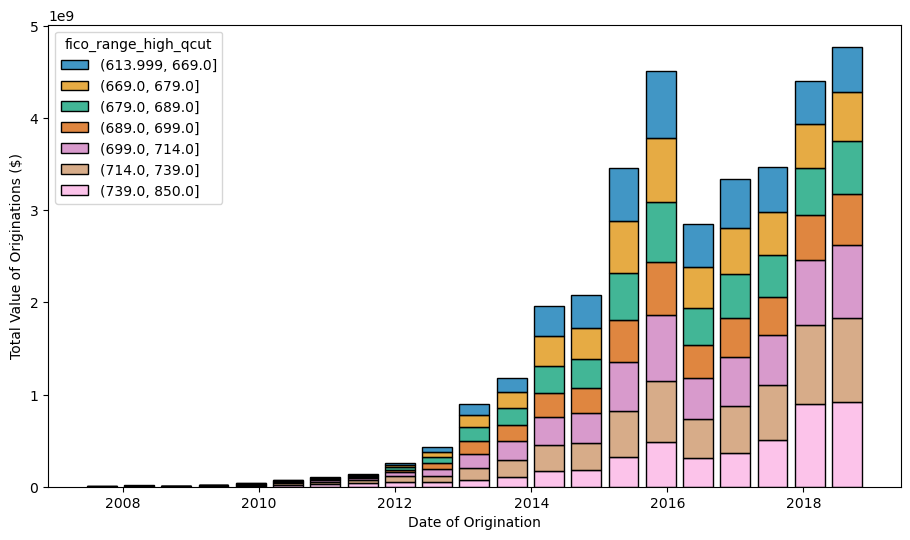

In [16]:
originations_timeline(df, 'fico_range_high_qcut')

### Plots of originations as a function of loan status

The plot below offers a stark indicatation of the limitations of basing our portfolio analysis on a single month's snapshot, as is available to us here.

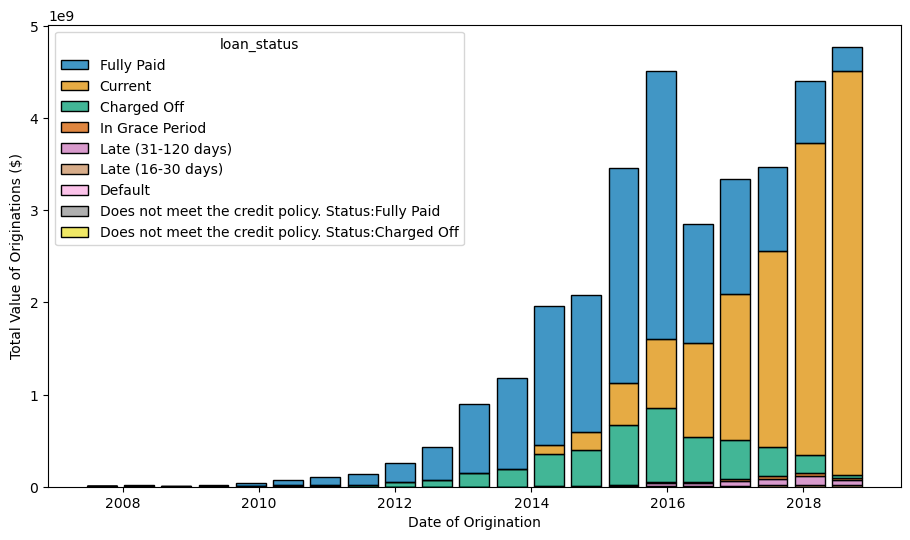

In [17]:
originations_timeline(df, 'loan_status')

### Quantification of the change in the categorical attribute distribution over time

The Jensen-Shannon Divergence (JSD) is a measure of similarity between two probability distributions, which can be used to quantify how the profile of any given month's originations deviate from the whole. Below it is calculated for the 5 attributes we have looked at above as a function of time. 

The first 4 attributes we've looked at are relatively flat as we would expect, given how consistent they appear to be over time. It's also  clear to see how `loan_status` follows a much sharper 'V' shape, indicating that the status distribution is only momentarily consistent with the whole in mid-2016, then immediately deviates in both directions. Such a change in the distribution is going to be problematic when it comes to modelling risk in the traditional manner as the dataset is far from homogeneous.

In [18]:
from scipy.spatial.distance import jensenshannon

In [19]:
df_jensenshannon = df.melt(id_vars='issue_d', value_vars=['term', 'purpose', 'int_rate_qcut', 'fico_range_high_qcut', 'loan_status'])
distributions_alltime = df_jensenshannon.groupby(['variable']).value.value_counts(normalize=True)
df_jensenshannon = df_jensenshannon.groupby(['issue_d', 'variable'], observed=False).value.value_counts(normalize=True)
df_jensenshannon = df_jensenshannon.unstack('issue_d').stack(future_stack=True).fillna(0)
df_jensenshannon = df_jensenshannon.to_frame().merge(distributions_alltime, left_index=True, right_index=True)
df_jensenshannon = df_jensenshannon.groupby(['issue_d', 'variable']).apply(lambda x: jensenshannon(x[0], x.proportion)).to_frame()

Text(0, 0.5, 'Jensen-Shannon Divergence')

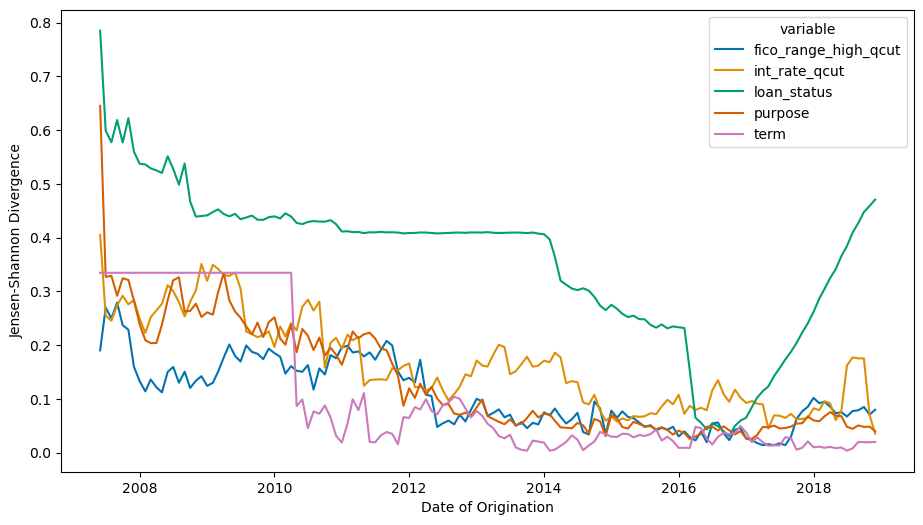

In [20]:
plt.figure(figsize=(11, 6))
ax = sns.lineplot(df_jensenshannon, x='issue_d', y=0, hue='variable', palette='colorblind')
ax.set_xlabel('Date of Origination')
ax.set_ylabel('Jensen-Shannon Divergence')

### Inflate the dataset to represent the full monthly timeseries from the point of origination up to the true report date

Given that the dataset provided includes only a single monthly snapshot, we are observing the loans as radically different points in the credit lifecycle, from those originated just 3 months prior to those that were closed more than a decade previously. For those loans that are closed today, which of them were paid early, and which were paid late? Of those which were paid late, which were a result of interest-free deferments or unsanctioned periods of arrears? And of those that are currently up to date which have encountered difficulies? For example, we still observe some loans that are up to date even after more than the maximum 60 month term.

In [21]:
(snapshot_date - df[df.loan_status=='Current'].issue_d.min()).days / 365.2425

5.412842152816279

To do accurate credit risk modelling, we need a full representation of the full history of the accounts, which will us to compare a a loan issued in 2007 with one issued in 2017 at the same point in their relative cycles. Credit risk management is inherently a timeseries problem: how has the portfolio performed in the past, and what level of risk are we exposed to today given how we anticipate the portfolio to perform in the future? To generate a dataset that is more suitable, we need to enumerate the full timeseries of monthly intervals and perform some simulations to infer how we expect events to unfolded leading up to April 2019.

First we'll need to determine what was the anticipated schedule of payments for the loan given the `installment` value and term, and for this we need the expected maturity date.

In [22]:
loan_attributes = [
    'id', 'term', 'issue_d', 'installment', 'last_pymnt_d', 'total_pymnt', 'loan_status', 'recoveries', 'last_pymnt_amnt',
    #'id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'issue_d', # origination details
    #'loan_status', 'pymnt_plan', 'hardship_flag', 'debt_settlement_flag',                              # account status
    #'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',        # details of receipts 
    #'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d'                                                  # important dates
]
df = df[loan_attributes].copy()

In [23]:
df['term_numeric'] = pd.to_numeric(df.term.str.replace('months', ''), errors='coerce')
df['maturity_d'] = df.issue_d.dt.year + (df.term_numeric/12).astype(int)
df['maturity_d'] = df.apply(lambda x: pd.Timestamp(year=x.maturity_d, month=x.issue_d.month, day=x.issue_d.day), axis=1)

Now we can enumerate a timeseries of expected installments from the date of issue right up to the date when this snapshot was taken. As this timeseries may extend beyond the maturity date of the loan, we'll overwrite those anticipated `installment` values with n/a.

In [24]:
df_ts = df.issue_d.apply(lambda x: pd.date_range(x, snapshot_date, freq='MS', inclusive='right').tolist())
df = df.join(df_ts.rename('report_date').explode()).reset_index()

In [25]:
df

,index,id,term,issue_d,installment,last_pymnt_d,total_pymnt,loan_status,recoveries,last_pymnt_amnt,term_numeric,maturity_d,report_date
0,0,68407277,36 months,2015-12-01,123.03,2019-01-01,4421.723917,Fully Paid,0.0,122.67,36,2018-12-01,2016-01-01
1,0,68407277,36 months,2015-12-01,123.03,2019-01-01,4421.723917,Fully Paid,0.0,122.67,36,2018-12-01,2016-02-01
2,0,68407277,36 months,2015-12-01,123.03,2019-01-01,4421.723917,Fully Paid,0.0,122.67,36,2018-12-01,2016-03-01
3,0,68407277,36 months,2015-12-01,123.03,2019-01-01,4421.723917,Fully Paid,0.0,122.67,36,2018-12-01,2016-04-01
4,0,68407277,36 months,2015-12-01,123.03,2019-01-01,4421.723917,Fully Paid,0.0,122.67,36,2018-12-01,2016-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76759594,2260667,88215728,60 months,2016-10-01,329.33,2019-03-01,9621.250000,Current,0.0,329.33,60,2021-10-01,2018-11-01
76759595,2260667,88215728,60 months,2016-10-01,329.33,2019-03-01,9621.250000,Current,0.0,329.33,60,2021-10-01,2018-12-01
76759596,2260667,88215728,60 months,2016-10-01,329.33,2019-03-01,9621.250000,Current,0.0,329.33,60,2021-10-01,2019-01-01
76759597,2260667,88215728,60 months,2016-10-01,329.33,2019-03-01,9621.250000,Current,0.0,329.33,60,2021-10-01,2019-02-01


With the guess at what the monthly payments might have looked like given: the `loan_status` at the end of March 2019, the `last_pymnt_d` at that point, an the `total_pymnt` received.

Note: it should be possible to improve on this further given what we know about the breakdown between principal, interest and fees, and also the hardship flags, payment plans and settlements. This very basic attibution algorithm is intendeda as a placeholder to get us started with some simulations.

In [26]:
df.loc[df.report_date > df.maturity_d, 'installment'] = np.nan

In [27]:
from tqdm.auto import tqdm
tqdm.pandas()

In [28]:
def basic_pymnt_attr(loan):

    # spread the total payments made over the vector of months paid
    pymnt = loan.total_pymnt - loan.recoveries - loan.last_pymnt_amnt
    pymnt = pymnt / (loan.report_date < loan.last_pymnt_d).sum()
    pymnt.loc[loan.report_date >= loan.last_pymnt_d] = np.nan

    # calculate and surplus with respect to the initial schedule (indicative of paid early)
    surplus = np.maximum(0, pymnt - loan.installment)
    pymnt = pymnt - surplus

    # backload the surplus onto the last payment (will be 0 for charged off) and return
    pymnt.loc[loan.report_date == loan.last_pymnt_d] = surplus.sum() + loan.last_pymnt_amnt
    return pymnt.rename('pymnt')

In [29]:
df = df.groupby('id').progress_apply(basic_pymnt_attr).to_frame().reset_index(level=0).join(df.drop(columns=['id']))

  0%|          | 0/2260668 [00:00<?, ?it/s]

In [30]:
sample = df.id.drop_duplicates().sample(1).squeeze()
loan = df[df.id==sample].copy()
loan

,id,pymnt,index,term,issue_d,installment,last_pymnt_d,total_pymnt,loan_status,recoveries,last_pymnt_amnt,term_numeric,maturity_d,report_date
24188000,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2016-06-01
24188001,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2016-07-01
24188002,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2016-08-01
24188003,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2016-09-01
24188004,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2016-10-01
24188005,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2016-11-01
24188006,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2016-12-01
24188007,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2017-01-01
24188008,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2017-02-01
24188009,77911936,604.848788,708800,36 months,2016-05-01,605.12,2019-03-01,20565.13,Current,0.0,605.12,36,2019-05-01,2017-03-01


In [44]:
df_train = df[df.installment.notna()][['id', 'issue_d', 'term_numeric', 'installment', 'pymnt']]

In [46]:
df_train = df_train.groupby(['id', 'issue_d', 'term_numeric']).apply(
    lambda x: pd.Series({'installment': x.installment.tolist(), 'pymnt': x.pymnt.fillna(0).tolist()}), 
    include_groups=False)

In [48]:
df_train.reset_index().to_json('accepted_2007_to_2018Q4.jsonl.gz', orient='records', lines=True)